In [6]:
%load_ext autoreload
%autoreload 2

import sys
import os

# Dynamically add project root to sys.path
PROJECT_ROOT = os.path.abspath("..")  # Adjust if necessary
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

# Verify sys.path
print("Project root added to sys.path:", PROJECT_ROOT)


from src.adjustcls import *
from src.adjustl1 import *
from src.decomposer import *
from src.loadsimulation import *
from src.moments import *
from src.image import *

import matplotlib.pyplot as plt
# Set global rc parameters for plot appearance
plt.rcParams.update({
    'axes.titlesize': 12,            # Font size for the plot titles
    'axes.labelsize': 12,            # Font size for the x and y labels
    'legend.fontsize': 12,           # Font size for the legend
    'xtick.labelsize': 12,           # Font size for the x-tick labels
    'ytick.labelsize': 12,           # Font size for the y-tick labels
    'axes.linewidth': 2.,           # Width of the axes' lines
    'xtick.major.width': 3.25,       # Width of the major x-tick lines
    'ytick.major.width': 3.25,       # Width of the major y-tick lines
    'xtick.minor.width': 4.0,        # Width of the minor x-tick lines
    'ytick.minor.width': 4.0,        # Width of the minor y-tick lines
    'figure.titlesize': 12,          # Font size for figure titles
    'legend.handlelength': 2,        # Length of the legend lines
    'legend.handleheight': 0.7,      # Height of the legend markers
    'legend.labelspacing': 0.5,      # Vertical spacing between legend entries
    'lines.linewidth': 3.0,          # Line width for plot lines
    'lines.markersize': 3,           # Size of markers in plot lines
    'axes.grid': False,               # Enable grid on all plots
    'grid.alpha': 0.75,              # Set gridline transparency
    'grid.linestyle': '--',          # Set gridline style
    'grid.linewidth': 0.7,           # Set gridline width
    'grid.color': 'gray',            # Set gridline color
})

from scipy import stats
import math
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib.ticker import ScalarFormatter
from skimage.transform import downscale_local_mean, resize
from scipy.interpolate import CubicSpline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root added to sys.path: /Users/vt272285/Documents/Codes/GOLCONDA


The number of scales is:  5
the target pixelsize is:  0.3097573567372225
the target size is:  (1024, 1024)
The number of scales is:  5
 Iteration: 9 Scale: 5

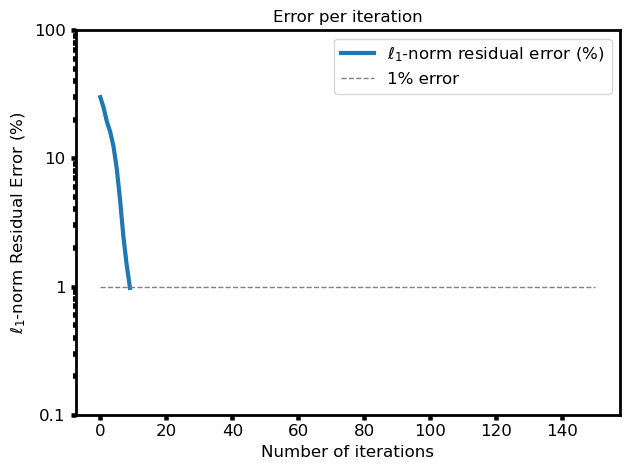

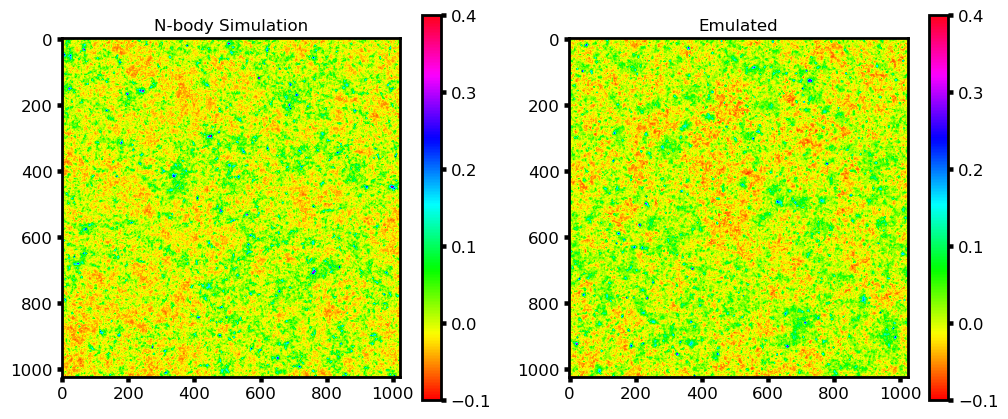

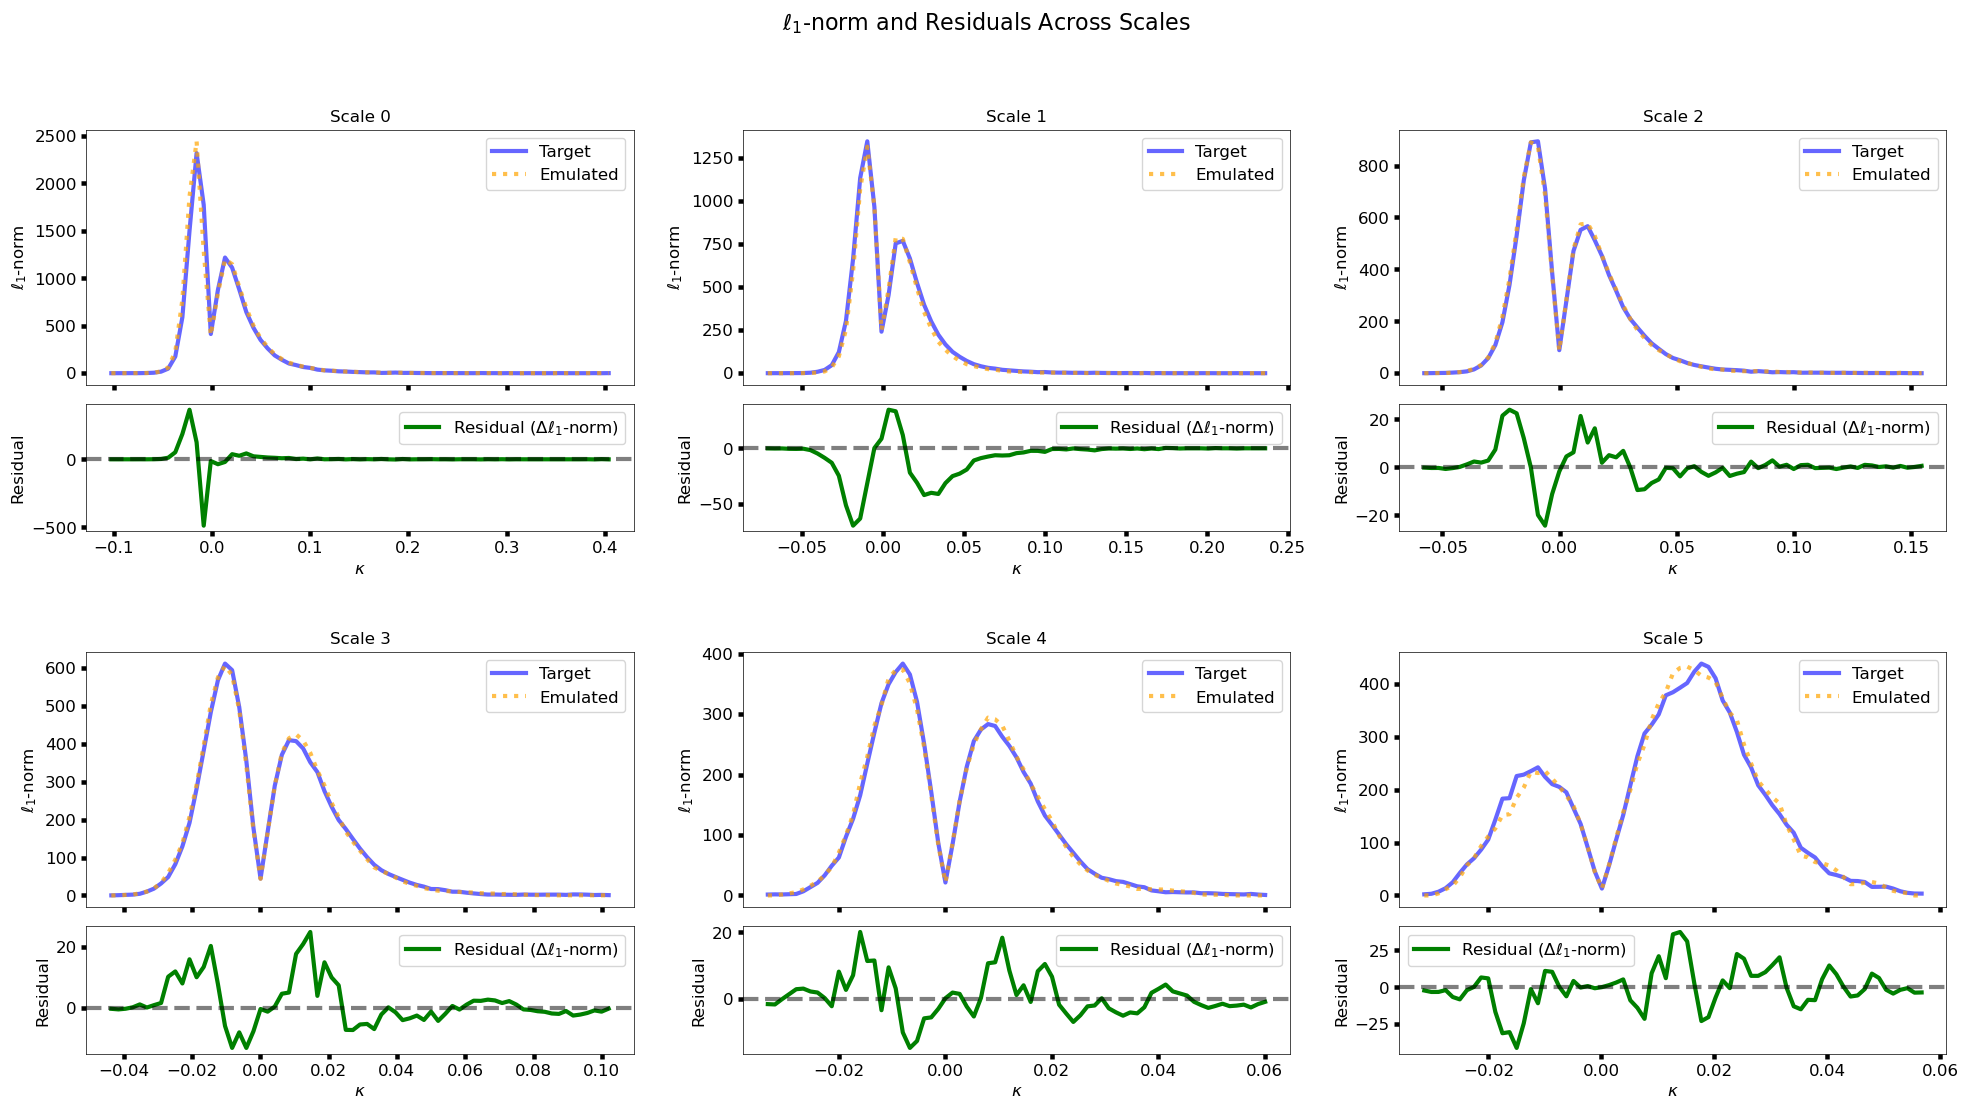

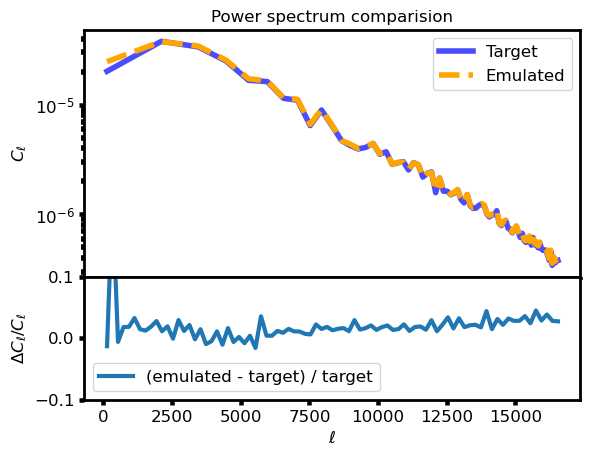

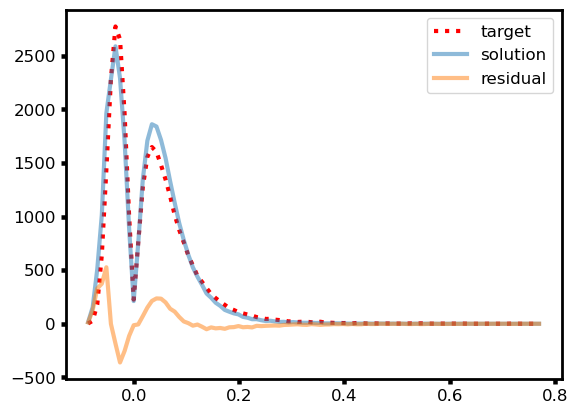

In [8]:
path = '../data/2.007kappa_weight.dat_LOS400'
angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 

loaded_data, loaded_angle = loader.load_data(path)
data_downscaled = downscale_local_mean(loaded_data-np.mean(loaded_data), (4, 4))

N = 1024
filter_type = 'tophat'
nscales = 5
print("The number of scales is: ", nscales)
nbins = [71]*(nscales+1)
target = data_downscaled[:N,:N]
pixelsize = loaded_angle.value * 60 / data_downscaled.shape[0]  # arcmin
print("the target pixelsize is: ", pixelsize)
print("the target size is: ", target.shape)

# adjuster = PowerSpectrumAdjuster(map_shape=target.shape, pixel_size=pixelsize)
# target_ells, target_cls = adjuster.compute_power_spectrum(target)

pkadjuster = PowerSpectrum(target, pixelsize)
_, target_ells, target_cls = pkadjuster.calculate_Cls(target)

decomposer = WaveletDecomposer()
density = False
target_values = process_image(target, filter_type, nscales, nbins, decomposer, density=density)

# seed = 10
# np.random.seed(seed)
gaussian = np.random.normal(0., np.std(target), target.shape)

# adjuster = PowerSpectrumAdjuster(map_shape=gaussian.shape, pixel_size=pixelsize)
pkadjuster = PowerSpectrum(gaussian, pixelsize)
solution = gaussian
total_error = []


print("The number of scales is: ", nscales)
for iter in range(10):
    solution_coefs = decomposer.decompose(solution,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)
    error_per_scale = 0.
    for scale in range(nscales+1):
        print(f"\r Iteration: {iter} Scale: {scale}", end="", flush=True)
        
        solution_coefs[scale], err = adjust_map_l1(solution_coefs[scale], mask=None, targetvalues=target_values[f'scale_{scale}'], density=density)
        # solution_coefs[scale], err = adjust_pixel_values(solution_coefs[scale], mask=None, targetvalues=target_values[f'scale_{scale}'], density=density) 
        error_per_scale += err
        
    total_error.append(error_per_scale)
    solution_l1 = np.sum(solution_coefs, axis=0)
    
    if iter%1 ==0:
        # solution_cl = adjuster.adjust_map_cls(solution, target_cls, target_ells)
        solution_cl = pkadjuster.generate_field_with_target_cls(solution,  target_cls, target_ells)

        solution =  0.5 * (solution_cl + solution_l1)
    else:
        solution = solution_l1
      
    solution = np.clip(solution, np.min(target), np.max(target))
    # Save image for animation
    

###################################
plt.figure()
plt.plot(np.array(total_error)*100, label=r"$\ell_1$-norm residual error (%)")
plt.hlines(1, 0, 150, color='grey', label="1% error", ls="--", lw=1)
# plt.hlines(0.2, 0, 150, color='grey', label="0.1% error", ls="--", lw=1)

# Set y-axis to log scale
plt.yscale('log')

# Formatter: plain numbers, no decimal places
formatter = ScalarFormatter()
formatter.set_scientific(False)
formatter.set_useOffset(False)
plt.gca().yaxis.set_major_formatter(formatter)

# Ensure integers are shown (e.g., 0.1, 1, 10, 100)
plt.gca().set_yticks([0.1, 1, 10, 100])  # Adjust ticks as needed
plt.gca().set_yticklabels([str(int(t)) if t >= 1 else str(t) for t in [0.1, 1, 10, 100]])

plt.title('Error per iteration')
plt.xlabel('Number of iterations')
plt.ylabel(r'$\ell_1$-norm Residual Error (%)')
plt.legend()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12,5))
vmin = -0.1
vmax = 0.4
cmap ='hsv'
plt.subplot(1,2,1)
plt.imshow(target, vmin=vmin, vmax=vmax, cmap=cmap)
plt.title('N-body Simulation')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(solution, vmin=vmin, vmax=vmax, cmap=cmap)
plt.title('Emulated')
plt.colorbar()
plt.show()

solution_coefs = decomposer.decompose(solution,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)

# fig, axs = plt.subplots(1, nscales+1, figsize=(8*(nscales+1), 5))
# for scale in range(nscales+1):
#     edges_target = target_values[f'scale_{scale}']['binedges']
#     centers_target = target_values[f'scale_{scale}']['bincenters']
#     l1_target = target_values[f'scale_{scale}']['l1_norm']
#     solution_edges, solution_centers, solution_hist, solution_l1norm = calculate_histogram_l1norm(solution_coefs[scale], mask=None, nbins=edges_target, density=density)
    
#     axs[scale].plot(centers_target, l1_target, label='target', ls=":",c='r' )
#     axs[scale].plot(solution_centers, solution_l1norm, label='solution', alpha=0.5)
#     axs[scale].plot(centers_target,  solution_l1norm - l1_target , label='residual', alpha=0.5)
#     axs[scale].legend()
#     axs[scale].set_title(f'Scale {scale}')
#     axs[scale].set_xlabel(r"$\kappa$")
#     axs[scale].set_ylabel(r"$\ell_1$-norm")
#     axs[scale].set_ylim(np.min(solution_l1norm)-(np.max(solution_l1norm)/5), np.max(solution_l1norm)+(np.max(solution_l1norm)/5))
    
# plt.tight_layout()
# plt.show()

ncols = math.ceil((nscales + 1) / 2)
fig = plt.figure(figsize=(8 * ncols, 12))

# Outer grid: 2 rows (top/bottom half), ncols
outer = GridSpec(2, ncols, height_ratios=[1, 1], hspace=0.3)  # hspace between top and bottom halves

for scale in range(nscales + 1):
    row = 0 if scale < ncols else 1
    col = scale % ncols

    # Inner grid: 2 rows (main + residual) inside each outer cell
    inner = GridSpecFromSubplotSpec(
        2, 1, subplot_spec=outer[row, col], height_ratios=[2, 1], hspace=0.1  # small space between main/residual
    )

    ax_main = fig.add_subplot(inner[0])
    ax_resid = fig.add_subplot(inner[1], sharex=ax_main)

    # Get data
    edges_target = target_values[f'scale_{scale}']['binedges']
    centers_target = target_values[f'scale_{scale}']['bincenters']
    l1_target = target_values[f'scale_{scale}']['l1_norm']
    
    solution_edges, solution_centers, solution_hist, solution_l1norm = calculate_histogram_l1norm(
        solution_coefs[scale], mask=None, nbins=edges_target, density=density)

    # Main plot
    ax_main.plot(centers_target, l1_target, label='Target', color='blue',alpha=0.6)
    ax_main.plot(solution_centers, solution_l1norm, label='Emulated', alpha=0.7, ls=":",c='orange')
    ax_main.set_title(f'Scale {scale}')
    ax_main.set_ylabel(r"$\ell_1$-norm")
    ax_main.legend()
    ax_main.tick_params(labelbottom=False)

    # Residual plot
    residual = solution_l1norm - l1_target
    ax_resid.plot(centers_target, residual, label=r'Residual ($\Delta \ell_1$-norm)', color='green')
    ax_resid.axhline(0, color='k', linestyle='--', alpha=0.5)
    ax_resid.set_xlabel(r"$\kappa$")
    ax_resid.set_ylabel("Residual")
    # ax_resid.set_ylim(-0.1,0.1)
    ax_resid.legend()

# Thin borders
for ax in fig.axes:
    for spine in ax.spines.values():
        spine.set_linewidth(0.5)

plt.suptitle(r"$\ell_1$-norm and Residuals Across Scales", fontsize=16)
plt.show()

gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0) 
plt.subplot(gs[0])
plt.plot(target_ells[1:], target_cls[1:], label='Target', lw=4, c='blue', alpha=0.7)
_, solutionells, solutioncls = pkadjuster.calculate_Cls(solution)
plt.plot(solutionells[1:], solutioncls[1:], label='Emulated', c='orange', ls="--", lw=4)
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Power spectrum comparision')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

plt.subplot(gs[1])
solution_cls_spline = CubicSpline(solutionells, solutioncls)
plt.plot(target_ells, (solution_cls_spline(target_ells) - target_cls)/target_cls, label='(emulated - target) / target')
plt.ylim(-0.1, 0.1)
plt.ylabel(r'$\Delta C_\ell / C_\ell$')
plt.xlabel(r'$\ell$')
plt.legend()
plt.show()

edges_target, center_target, hist_target, l1_target = calculate_histogram_l1norm(target, mask=None, nbins=100, density=density)
edges_solution, center_solution, hist_solution, l1_solution = calculate_histogram_l1norm(solution, mask=None, nbins=edges_target, density=density)

plt.figure()
plt.plot(center_target, l1_target, label='target', ls=":",c='r' )
plt.plot(center_solution, l1_solution, label='solution', alpha=0.5)
plt.plot(center_target,  l1_solution - l1_target , label='residual', alpha=0.5)
plt.legend()
plt.show()

Text(0.5, 0, 'Map Size')

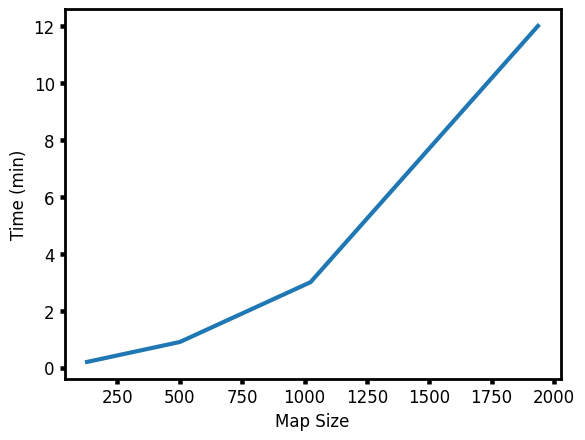

In [3]:
plt.figure()
x = [128,500,1024,1936]
y = [0.2,0.9,3,12]

plt.plot(x,y)
plt.ylabel('Time (min)')
plt.xlabel("Map Size")

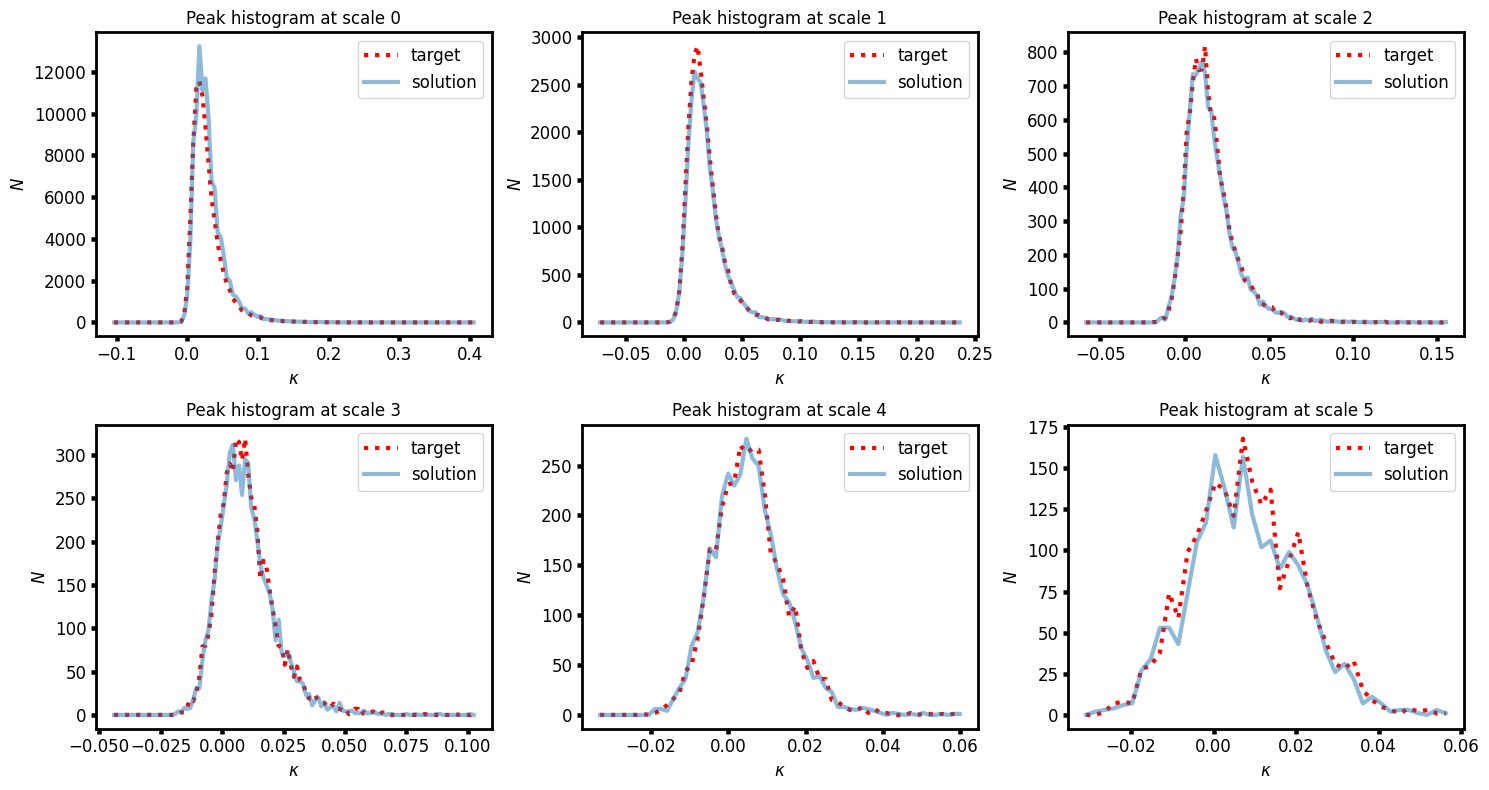

In [21]:
import lenspack

target_coef = decomposer.decompose(target,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)
solution_coef = decomposer.decompose(solution,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)


# plt.figure(figsize=(8,5))
# target_peak_count, target_peak_edges = lenspack.peaks.peaks_histogram(target_coef[1], bins=120, mask=None)
# sol_peak_count, sol_peak_edges = lenspack.peaks.peaks_histogram(solution_coef[1], bins=target_peak_edges, mask=None)
# center = 0.5*(target_peak_edges[1:] + target_peak_edges[:-1])
# plt.plot(center, target_peak_count, label='target', ls=":",c='r' )
# plt.plot(center, sol_peak_count, label='solution', alpha=0.5)
# # plt.plot(center,  sol_peak_count - target_peak_count , label='residual', alpha=0.5)
# plt.legend()
# plt.xlabel(r"$\kappa$")
# plt.ylabel(r"$N$")
# plt.title('Peak histogram at scale 1')
# plt.show()

# plt.figure(figsize=(8,5))
# target_peak_count, target_peak_edges = lenspack.peaks.peaks_histogram(target_coef[3], bins=50, mask=None)
# sol_peak_count, sol_peak_edges = lenspack.peaks.peaks_histogram(solution_coef[3], bins=target_peak_edges, mask=None)
# center = 0.5*(target_peak_edges[1:] + target_peak_edges[:-1])
# plt.plot(center, target_peak_count, label='target', ls=":",c='r' )
# plt.plot(center, sol_peak_count, label='solution', alpha=0.5)
# # plt.plot(center,  sol_peak_count - target_peak_count , label='residual', alpha=0.5)
# plt.legend()
# plt.xlabel(r"$\kappa$")
# plt.ylabel(r"$N$")
# plt.title('Peak histogram at scale 3')
# plt.show()

# plt.figure(figsize=(8,5))
# target_peak_count, target_peak_edges = lenspack.peaks.peaks_histogram(target, bins=200, mask=None)
# sol_peak_count, sol_peak_edges = lenspack.peaks.peaks_histogram(solution, bins=target_peak_edges, mask=None)
# center = 0.5*(target_peak_edges[1:] + target_peak_edges[:-1])
# plt.plot(center, target_peak_count, label='target', ls=":",c='r' )
# plt.plot(center, sol_peak_count, label='solution', alpha=0.5)
# # plt.plot(center,  sol_peak_count - target_peak_count , label='residual', alpha=0.5)
# plt.legend()
# plt.xlabel(r"$\kappa$")
# plt.ylabel(r"$N$")
# plt.title('Peak histogram of the maps')
# plt.show()

# Set up subplots
nrows = (nscales + 1 + 2) // 3  # 3 plots per row
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(15, 4 * nrows))
axes = axes.flatten()

# Plot for each scale
for j in range(nscales + 1):
    ax = axes[j]
   
    if j <= 3:
        bins = 120
    elif j == 4:
        bins = 61
    else:
        bins = 41 
    target_peak_count, target_peak_edges = lenspack.peaks.peaks_histogram(target_coef[j], bins=bins, mask=None)
    sol_peak_count, _ = lenspack.peaks.peaks_histogram(solution_coef[j], bins=target_peak_edges, mask=None)
    center = 0.5 * (target_peak_edges[1:] + target_peak_edges[:-1])
    
    ax.plot(center, target_peak_count, label='target', ls=":", c='r')
    ax.plot(center, sol_peak_count, label='solution', alpha=0.5)
    ax.set_title(f'Peak histogram at scale {j}')
    ax.set_xlabel(r"$\kappa$")
    ax.set_ylabel(r"$N$")
    ax.legend()

# Turn off any unused subplots
for i in range(nscales + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

1937 0.3097573567372225


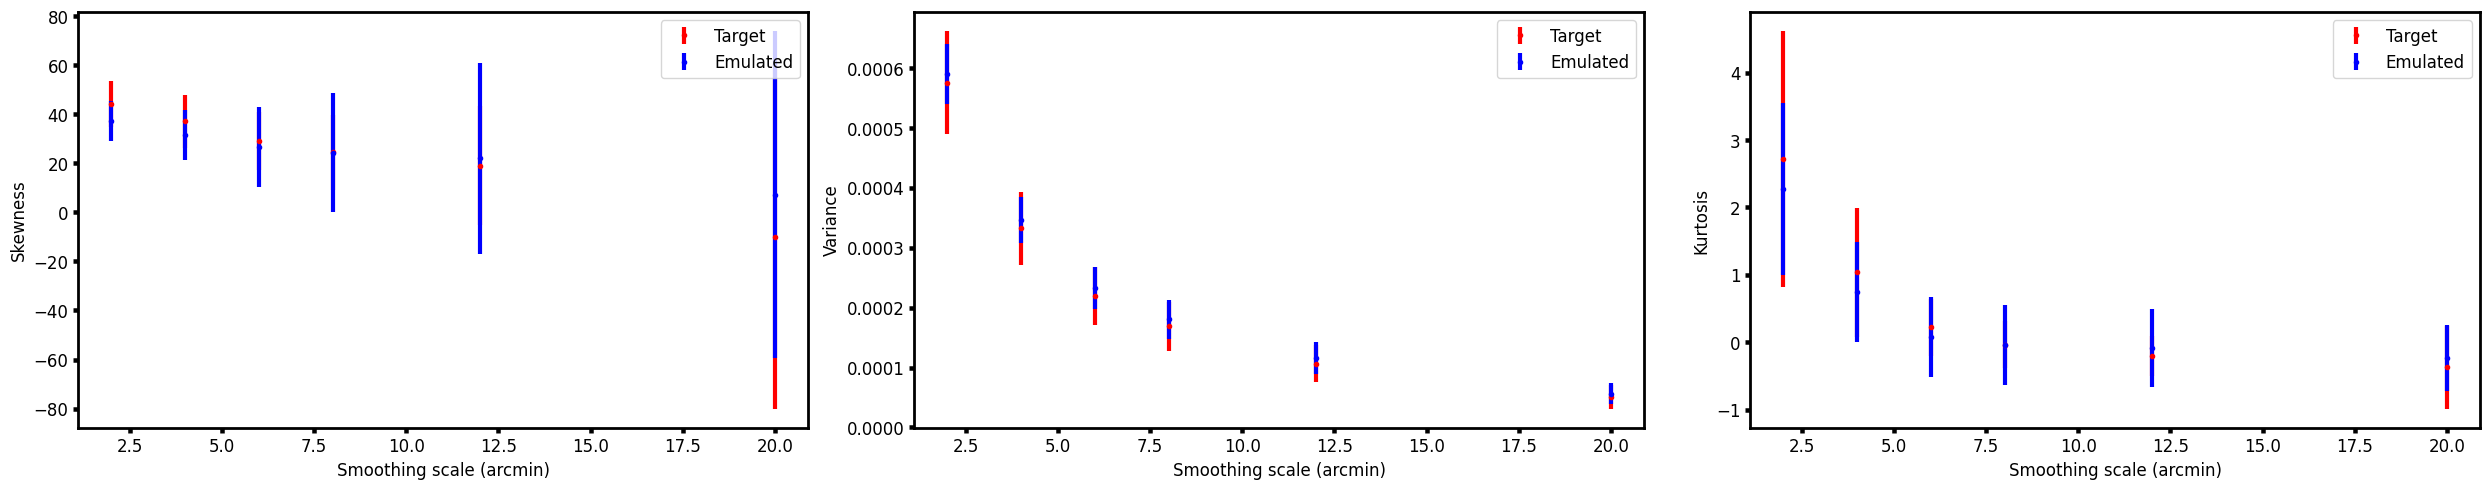

array([ 6, 12, 19, 25, 38, 64])

In [5]:


N_mesh = data_downscaled.shape[0]
target_image = target
final_map = solution
L = 505
pixsize=pixelsize #arcmin
print(N_mesh, pixsize)

theta1 = np.array([2,4,6,8, 12, 20]) 
theta1_pixels = (theta1/pixsize).astype(int)

fig, axs = plt.subplots(1, 3, figsize=(25, 5))
# Flags to control labeling in the legend
first_label_target = True
first_label_emulated = True

for i, theta1s in enumerate(theta1_pixels):
    emulated_smoothed = decomposer.get_th_smooth_map(final_map, theta1s) 
    target_smoothed = decomposer.get_th_smooth_map(target_image, theta1s) 
    emu_patches = split_image_into_patches(emulated_smoothed, 4)
    tar_patches = split_image_into_patches(target_smoothed, 4)
    
    emu_mean = []
    emu_variance = []
    emu_skewness = []
    emu_kurtosis = []
    tar_mean = []
    tar_variance = []
    tar_skewness = []
    tar_kurtosis = []
    for no_patch in range(len(emu_patches)):
        emulated_mean, emulated_variance, emulated_skewness, emulated_kurtosis = get_moments_from_map(emu_patches[no_patch])
        target_mean, target_variance, target_skewness, target_kurtosis = get_moments_from_map(tar_patches[no_patch])
        emu_mean.append(emulated_mean)
        emu_variance.append(emulated_variance)
        emu_skewness.append(emulated_skewness)
        emu_kurtosis.append(emulated_kurtosis)
        tar_mean.append(target_mean)
        tar_variance.append(target_variance)
        tar_skewness.append(target_skewness)
        tar_kurtosis.append(target_kurtosis)
    
    
    axs[0].errorbar(theta1[i], np.average(tar_skewness), yerr=np.std(tar_skewness), c='r', label='Target' if first_label_target else "", fmt='o')
    axs[0].errorbar(theta1[i], np.average(emu_skewness), yerr=np.std(emu_skewness),fmt='o', c='b')
    axs[0].set_xlabel("Smoothing scale (arcmin)")
    axs[0].set_ylabel("Skewness")
    
    axs[1].errorbar(theta1[i], np.average(tar_variance),yerr=np.std(tar_variance),fmt='o', c='r', label='Target' if first_label_target else "")
    axs[1].errorbar(theta1[i], np.average(emu_variance),yerr=np.std(emu_variance),fmt='o', c='b')
    axs[1].set_xlabel("Smoothing scale (arcmin)")
    axs[1].set_ylabel("Variance")
    
    axs[2].errorbar(theta1[i], np.average(tar_kurtosis), c='r', yerr=np.std(tar_kurtosis), fmt='o',label='Target' if first_label_target else "")
    axs[2].errorbar(theta1[i], np.average(emu_kurtosis), yerr=np.std(emu_kurtosis), fmt='o', c='b')
    axs[2].set_xlabel("Smoothing scale (arcmin)")
    axs[2].set_ylabel("Kurtosis")
   
# Fetch unique handles and labels after plotting
handles_skewness, labels_skewness = axs[0].get_legend_handles_labels()
handles_variance, labels_variance = axs[1].get_legend_handles_labels()
handles_kurtosis, labels_variance = axs[2].get_legend_handles_labels()

# Create legends
axs[0].legend(['Target', 'Emulated'], loc='best')
axs[1].legend(['Target', 'Emulated'], loc='best')
axs[2].legend(['Target', 'Emulated'], loc='best')


plt.tight_layout()
plt.show()
# theta1 = np.array([2, 12])
# theta1_pixels = (theta1/pixsize).astype(int) 
# fig, axs = plt.subplots(2, len(theta1), figsize=(15, 10)) 
# theta1 = np.array([2, 12, 20]) 
# for i, theta1s in enumerate(theta1_pixels):
#     emulated_smoothed = decomposer.get_th_smooth_map(final_map, theta1s) 
#     target_smoothed = decomposer.get_th_smooth_map(target_image, theta1s) 
#     emu_patches = split_image_into_patches(emulated_smoothed, 2)
#     tar_patches = split_image_into_patches(target_smoothed, 2)
#     counts_emu_ = []
#     counts_tar_ = []
#     for patch_no in range(4):
#         if patch_no==0:
#             edges_emulated, bin_centers_emulated, counts_emulated, l1norm_emulated = calculate_histogram_l1norm(emu_patches[patch_no], None, 50, density=True)
#         #     edges_target, bin_centers_target, counts_target, l1norm_target = calculate_histogram_l1norm(tar_patches[patch_no], None, edges_emulated, density=True)
#         # else:
#         _, bin_centers_emulated, counts_emulated, l1norm_emulated = calculate_histogram_l1norm(emu_patches[patch_no], None, edges_emulated, density=True) 
#         _, bin_centers_target, counts_target, l1norm_target = calculate_histogram_l1norm(tar_patches[patch_no], None, edges_emulated, density=True)
            
#         counts_emu_.append(counts_emulated)
#         counts_tar_.append(counts_target)
#     counts_emu_ = np.array(counts_emu_)
#     counts_tar_ = np.array(counts_tar_)
#     axs[0, i].errorbar(
#         bin_centers_target, 
#         np.mean(counts_tar_, axis=0), 
#         yerr=np.std(counts_tar_, axis=0), 
#         fmt='o', 
#         label="Target", 
#         markersize=5, 
#         linestyle=":"
#     )

#     axs[0, i].errorbar(
#         bin_centers_emulated, 
#         np.mean(counts_emu_, axis=0), 
#         yerr=np.std(counts_emu_, axis=0), 
#         fmt='h', 
#         label="Emulated", 
#         markersize=5, 
#         linestyle="--"
#     )

#     # axs[0,i].plot(bin_centers_emulated, counts_emulated, ls=":")
#     # axs[0,i].set_yscale('log')
#     axs[0,i].legend()
#     axs[0,i].set_title(f'Scale {theta1[i]} arcmin')
#     axs[0,i].set_xlabel("$\kappa$")
#     axs[0,i].set_ylabel("Counts")
    
#     axs[1,i].plot(bin_centers_target, (np.mean(counts_emu_,axis=0)/(np.mean(counts_tar_,axis=0) + 1e-10)) - 1, label=theta1[i])
#     axs[1,i].set_ylim(-0.3,0.3)
#     axs[1,i].set_xlabel("$\kappa$")
#     axs[1,i].set_ylabel("Emulated - Target / Target")
#     axs[1,i].set_xlim(np.mean(emulated_smoothed)-1.5*np.std(emulated_smoothed), np.mean(emulated_smoothed)+1.5*np.std(emulated_smoothed))
    
# plt.tight_layout()
# plt.show()

 
theta1_pixels

## Theory Prediction

In [6]:
def compute_binedges(bincenters):
    """
    Compute bin edges from bin centers.

    Parameters:
        bincenters (numpy.ndarray): Array of bin centers.

    Returns:
        numpy.ndarray: Array of bin edges.
    """
    # Calculate bin widths (differences between consecutive bin centers)
    bin_widths = np.diff(bincenters)

    # Initialize an array for edges
    edges = np.zeros(len(bincenters) + 1)
    edges[1:-1] = bincenters[:-1] + bin_widths / 2  # Midpoints between centers

    # Add the first and last edges
    edges[0] = bincenters[0] - 0.5 * bin_widths[0]
    edges[-1] = bincenters[-1] + 0.5 * bin_widths[-1]

    return edges

Processing LOS /feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS406: Data shape = (300, 300), Pixel size = 2.00 arcmin


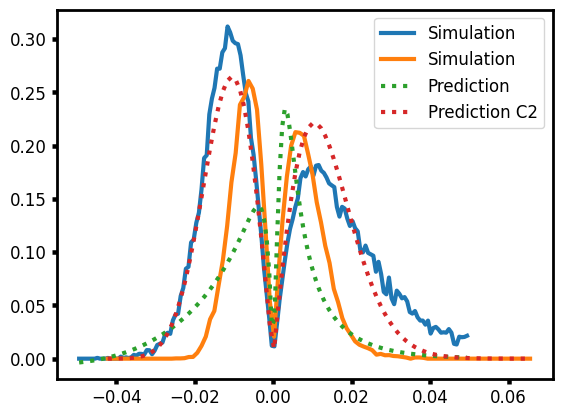

In [7]:
theoryw0 = np.load('/feynman/work/dap/lcs/vt272285/LDT_2cell_l1_norm/slics_data_for_emulator/theory_values_2_134_2.npy')
theoryw1 = np.load('/feynman/work/dap/lcs/vt272285/LDT_2cell_l1_norm/slics_data_for_emulator/theory_values_2_134_4.npy')
theoryw2 = np.load('/feynman/work/dap/lcs/vt272285/LDT_2cell_l1_norm/slics_data_for_emulator/theory_values_2_134_8.npy')
theoryc2 = np.load('/feynman/work/dap/lcs/vt272285/LDT_2cell_l1_norm/slics_data_for_emulator/16.npy')

base_path = '/feynman/work/dap/lcs/vt272285/data/SLICS/2.007kappa_weight.dat_LOS406'

angle = 10
loader = SimulationDataLoader(user_defined_angle=angle) 
loaded_data, loaded_angle = loader.load_data(base_path)
data_downscaled = resize(loaded_data, (300, 300))

pixelsize = loaded_angle.value * 60 / data_downscaled.shape[0]  # arcmin

print(f"Processing LOS {base_path}: Data shape = {data_downscaled.shape}, Pixel size = {pixelsize:.2f} arcmin")
    
nbins = [101, 101, 101, 101, 101, 101, 101]
nscales = 3
filter_type = 'tophat'

# target = data_downscaled[:-1,:-1]
target = data_downscaled



kappaw0 = -theoryw0.T[0]
sortindices = np.argsort(kappaw0)
kappaw0 = kappaw0[sortindices]
edgesw0 = compute_binedges(kappaw0)
predictionl1w0 = theoryw0.T[2][sortindices]
predictionhistw0 = theoryw0.T[1][sortindices]
# Define new 100-bin edges ensuring 0 is included
new_edges = np.linspace(min(kappaw0), max(kappaw0), 151)  # 101 edges for 100 bins
scaling_factor = 1 #np.abs(target.shape[0]*target.shape[1]*(new_edges[1]-new_edges[0]))
interp_hist = interp1d(kappaw0, predictionhistw0, kind='linear', fill_value='extrapolate')
interp_l1 = interp1d(kappaw0, predictionl1w0, kind='linear', fill_value='extrapolate')
kappaw0 = (new_edges[:-1] + new_edges[1:]) / 2
predictionhistw0 = interp_hist(kappaw0)/scaling_factor
predictionl1w0 = interp_l1(kappaw0)/scaling_factor
edgesw0 = new_edges


kappaw1 = -theoryw1.T[0]
sortindices = np.argsort(kappaw1)
kappaw1 = kappaw1[sortindices]
edgesw1 = compute_binedges(kappaw1)
predictionl1w1 = theoryw1.T[2][sortindices]
predictionhistw1 = theoryw1.T[1][sortindices]
new_edges = np.linspace(min(kappaw1), max(kappaw1), 151)
scaling_factor = 1 #np.abs(target.shape[0]*target.shape[1]*(new_edges[1]-new_edges[0]))
interp_hist = interp1d(kappaw1, predictionhistw1, kind='linear',   fill_value='extrapolate')
interp_l1 = interp1d(kappaw1, predictionl1w1, kind='linear', fill_value='extrapolate')
kappaw1 = (new_edges[:-1] + new_edges[1:]) / 2
predictionhistw1 = interp_hist(kappaw1)*scaling_factor
predictionl1w1 = interp_l1(kappaw1)*scaling_factor
edgesw1 = new_edges

kappaw2 = -theoryw2.T[0]
sortindices = np.argsort(kappaw2)
kappaw2 = kappaw2[sortindices]
edgesw2 = compute_binedges(kappaw2)
predictionl1w2 = theoryw2.T[2][sortindices]
predictionhistw2 = theoryw2.T[1][sortindices]
new_edges = np.linspace(min(kappaw2), max(kappaw2), 151)
scaling_factor = 1 #np.abs(target.shape[0]*target.shape[1]*(new_edges[1]-new_edges[0]))
interp_hist = interp1d(kappaw2, predictionhistw2, kind='linear', fill_value='extrapolate')
interp_l1 = interp1d(kappaw2, predictionl1w2, kind='linear', fill_value='extrapolate')
kappaw2 = (new_edges[:-1] + new_edges[1:]) / 2
predictionhistw2 = interp_hist(kappaw2)*scaling_factor
predictionl1w2 = interp_l1(kappaw2)*scaling_factor
edgesw2 = new_edges

kappac2 = theoryc2.T[0]
edgesc2 = compute_binedges(kappac2)
predictionl1c2 = theoryc2.T[2]
predictionhistc2 = theoryc2.T[1]
new_edges = np.linspace(min(kappac2), max(kappac2), 101)
interp_hist = interp1d(kappac2, predictionhistc2, kind='linear')
scaling_factor = 1 #np.abs(target.shape[0]*target.shape[1]*(new_edges[1]-new_edges[0]))
interp_l1 = interp1d(kappac2, predictionl1c2, kind='linear')
kappac2 = (new_edges[:-1] + new_edges[1:]) / 2
predictionhistc2 = interp_hist(kappac2)*scaling_factor
predictionl1c2 = interp_l1(kappac2)*scaling_factor
edgesc2 = new_edges


decomposer = WaveletDecomposer()
target_coeffs = decomposer.decompose(target, num_scales=nscales, filter_type=filter_type, recalculate_params=True)
density=True
edges_w0 , centersw0, hist_w0, l1norm_w0 = calculate_histogram_l1norm(target_coeffs[0], None, edgesw0, density=density)
edges_w1, centersw1, hist_w1, l1norm_w1 = calculate_histogram_l1norm(target_coeffs[1], None, edgesw1, density=density)
edges_w2, centersw2, hist_w2, l1norm_w2 = calculate_histogram_l1norm(target_coeffs[2], None, edgesw2, density=density)
edges_c2, centersc2, hist_c2, l1norm_c2 = calculate_histogram_l1norm(target_coeffs[2], None, edgesc2, density=density)

plt.plot(centersw0, l1norm_w0, label='Simulation')
plt.plot(centersc2, l1norm_c2, label='Simulation')
plt.plot(kappaw1, predictionl1w1, label='Prediction', ls=":")
plt.plot(kappac2, predictionl1c2, label='Prediction C2', ls=":")
plt.legend()
plt.show()



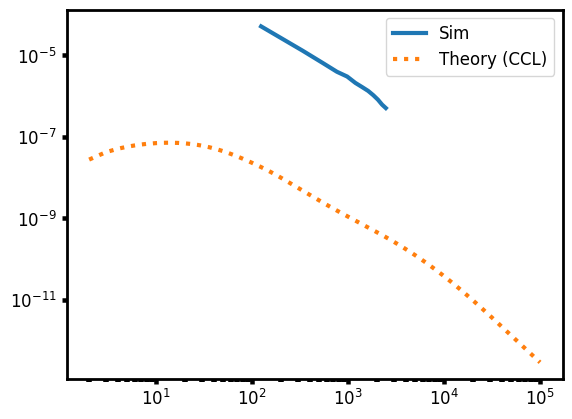

In [8]:
def measure_power_spectrum(map_data, pixel_size):
    """
    Measures the 1D power spectrum of a 2D map, ensuring ℓ is physically scaled.
    """
    n = map_data.shape[0]  # Image size (n x n)
    data_ft = np.fft.fft2(map_data)
    power_spectrum_2d = np.abs(data_ft)**2 / (n * n)  # Normalization
    power_spectrum_2d = np.fft.fftshift(power_spectrum_2d)  # Center zero frequency
    
    # Compute spatial frequencies (cycles/radian) for both axes
    freq_x = np.fft.fftshift(np.fft.fftfreq(n, d=pixel_size))  # 1D frequencies (1/rad)
    freq_y = np.fft.fftshift(np.fft.fftfreq(n, d=pixel_size))

    # Create 2D grid of frequencies
    u, v = np.meshgrid(freq_x, freq_y)
    k_mag = np.sqrt(u**2 + v**2)  # Magnitude of spatial frequency (always positive)

    # Compute ℓ for each pixel
    ell_2d = 2  * np.pi * k_mag 
    
    # Bin radially by |k_freq| (or equivalently ℓ)
    ell_flat = ell_2d.ravel()
    power_flat = power_spectrum_2d.ravel()

    # Define bins for ℓ
    max_ell = ell_flat.max()
    ell_bins = np.linspace(0, max_ell, num=100)  # Adjust bin count as needed
    ell_centers = (ell_bins[1:] + ell_bins[:-1]) / 2

    # Bin the power spectrum
    power_1d, _, _ = stats.binned_statistic(
        ell_flat, power_flat, statistic="mean", bins=ell_bins
    )
    return ell_centers, power_1d*pixel_size*pixel_size

def adjust_cls(map, pixel_size, target_ells, target_cls):
    map_ft = fftn(map)
    n = map.shape[0]
    dx = np.pi * pixel_size / (180 * 60)  # Pixel size in radians
    nyquist_freq = np.pi / dx

    # Compute Fourier grid
    lx = 2 * np.pi * np.fft.fftfreq(n, d=dx)
    ly = 2 * np.pi * np.fft.fftfreq(n, d=dx)
    ly_grid, lx_grid = np.meshgrid(ly, lx, indexing='ij')
    l = np.sqrt(lx_grid**2 + ly_grid**2)
    mask = l <= nyquist_freq  # Nyquist mask

    # Interpolate target Cl up to Nyquist
    valid_ells = target_ells[target_ells <= nyquist_freq]
    valid_cls = target_cls[target_ells <= nyquist_freq]
    cl_interp = interp1d(valid_ells, valid_cls, bounds_error=False, fill_value=0.0)
    CLTarget2d = cl_interp(l)

    ell_input, power_spectrum_1d_input = measure_power_spectrum(map, dx)
    cl_interp_input = interp1d(ell_input, power_spectrum_1d_input, bounds_error=False, fill_value=power_spectrum_1d_input[-1])
    CLInput2d = cl_interp_input(l)

    # Apply damping and mask
    epsilon = 1e-20
    scaling = np.ones_like(l)
    scaling[mask] = np.sqrt((CLTarget2d[mask] / (CLInput2d[mask] + epsilon)) )

    # Adjust FFT and normalize
    adjusted_fft = np.abs(map_ft) * scaling * np.exp(1j * np.angle(map_ft))
    adjusted_map = ifft2(adjusted_fft).real 

    return adjusted_map

import pyccl as ccl
h = 0.6898
Om = 0.2905
Ob = 0.0473
Oc = Om - Ob
Ol = 0.7095
mnu = 0
ns = 0.969

def get_weak_lensing_cl(zs, H0=h*100, ombh2=Ob*h*h, omch2=Oc*h*h, 
                        ns=0.9649, As=2.1e-9, max_l=100000):
    """
    Compute the weak lensing convergence power spectrum for a source redshift `zs` using CCL.
    
    Parameters:
    - zs: Source redshift
    - H0: Hubble parameter (km/s/Mpc)
    - ombh2: Baryon density parameter (Ω_b h²)
    - omch2: Cold dark matter density parameter (Ω_c h²)
    - ns: Scalar spectral index
    - As: Scalar amplitude (at k=0.05 Mpc⁻¹)
    - max_l: Maximum multipole ℓ to compute
    
    Returns:
    - ells: Array of multipoles (ℓ)
    - cl_kappa: Convergence power spectrum Cℓ^κκ
    """
    h = H0 / 100.0
    Omega_b = ombh2 / h**2
    Omega_c = omch2 / h**2

    # Initialize cosmology with Halofit nonlinear corrections
    cosmo = ccl.Cosmology(
        Omega_c=Omega_c,
        Omega_b=Omega_b,
        h=h,
        A_s=As,
        n_s=ns,
        matter_power_spectrum='halofit',  # Enable nonlinear corrections
        transfer_function='boltzmann_camb'  # Match CAMB's transfer function
    )

    # Create a narrow Gaussian source distribution around zs
    sigma_z = 0.05  # Approximate delta function at zs
    z = np.linspace(zs - 5*sigma_z, zs + 5*sigma_z, 1000)
    n = np.exp(-0.5 * ((z - zs) / sigma_z)**2)
    n /= np.trapz(n, z)  # Normalize distribution

    # Create weak lensing tracer
    lens = ccl.WeakLensingTracer(cosmo, dndz=(z, n))

    # Compute angular power spectrum (convergence Cls)
    ells = np.arange(2, max_l + 1)
    cl_kappa = ccl.angular_cl(cosmo, lens, lens, ells)

    return ells, cl_kappa

zs = 2.137  # Source redshift
target_ells_th, target_cls_th = get_weak_lensing_cl(zs)

gaussian = np.random.normal(0., 0.2, (256,256))
pixel_size = 2.0
pixelsize_rad = np.pi * pixel_size / 180 / 60  # rad
adjusted = adjust_cls(gaussian.copy(), pixel_size, target_ells, target_cls)

g_ell, g_cls = measure_power_spectrum(gaussian, pixelsize_rad)
a_ell, a_cls = measure_power_spectrum(adjusted, pixelsize_rad)

pkadjuster = PowerSpectrum(target, pixelsize)
_, target_ells, target_cls = pkadjuster.calculate_Cls(target)

# plt.loglog(g_ell, g_cls, label='Gaussian')
# plt.loglog(a_ell, a_cls, label='Adjusted')
plt.loglog(target_ells, target_cls, label='Sim')
plt.loglog(target_ells_th, target_cls_th, label='Theory (CCL)', ls=":")
plt.legend()
plt.show()


(300, 300)
The number of scales is:  3
 Iteration: 79  Scale: 3
 the error at the end is:  1.9347397006819012


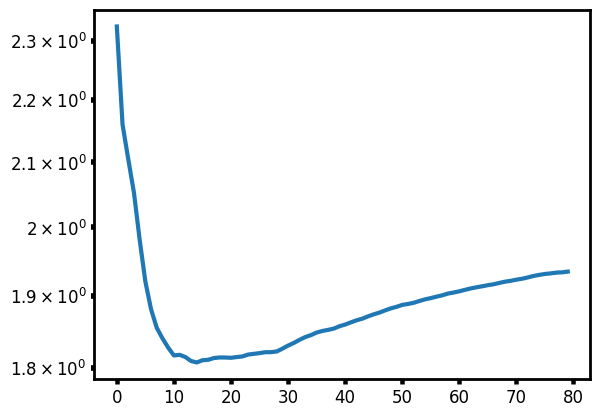

/tmp/ipykernel_2954331/394958187.py:64: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, max(solutionells+10))


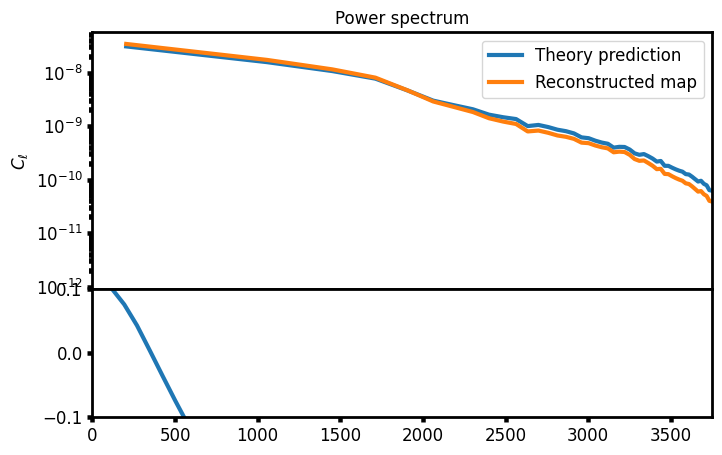

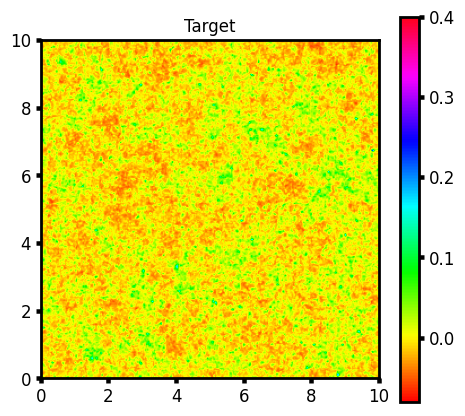

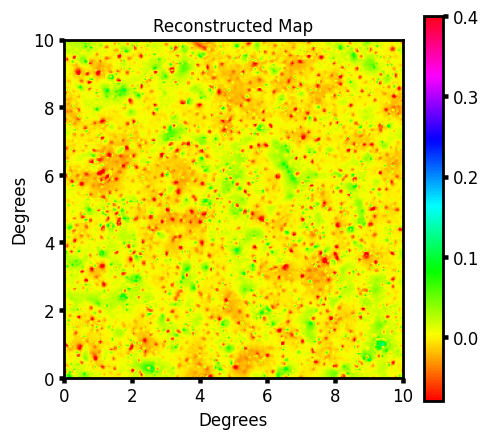

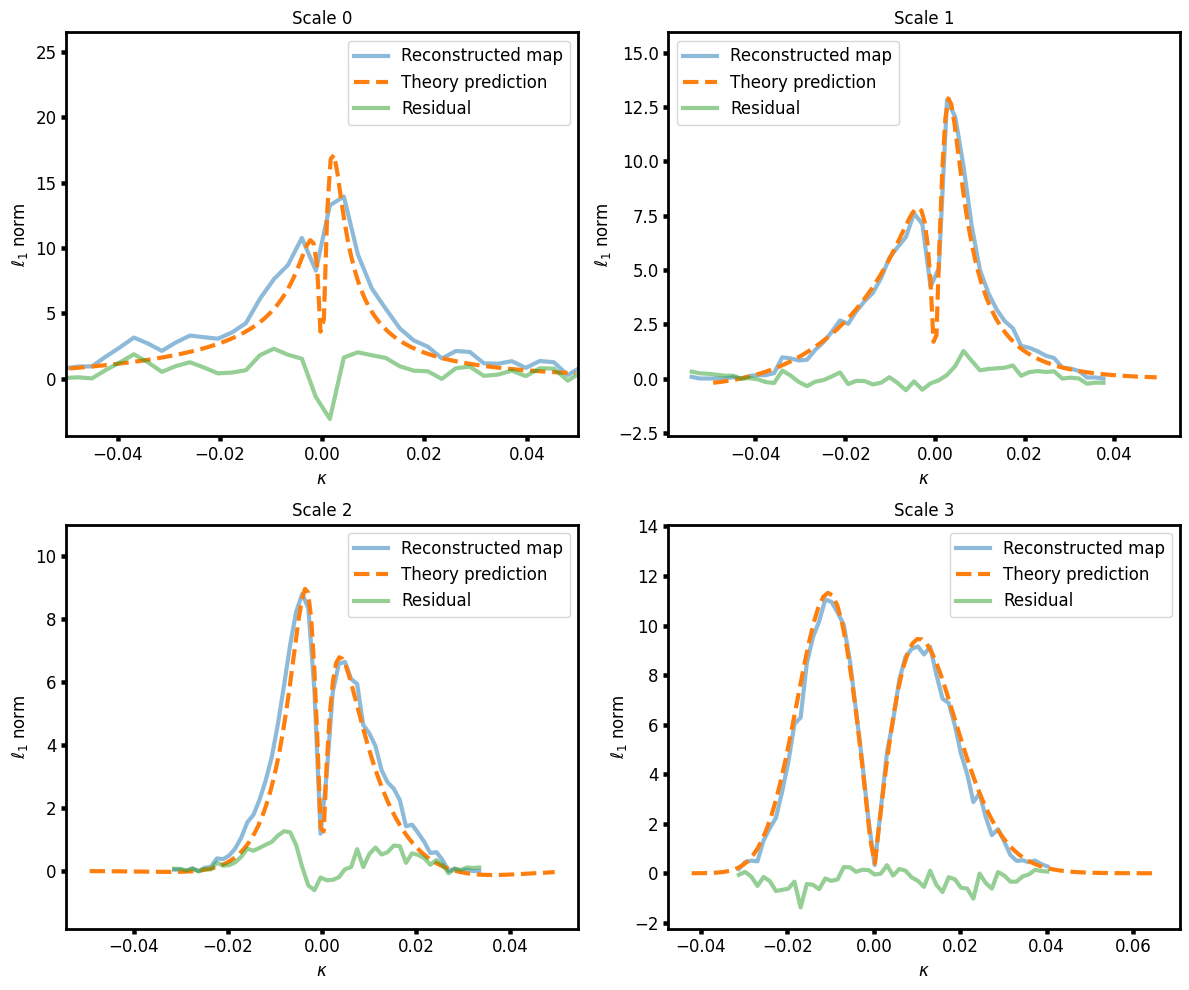

In [92]:
pixelsize = 2.0
pixelsize_rad = np.pi * pixelsize / 180 / 60  # rad

data_downscaled = resize(loaded_data, (300, 300))
target = data_downscaled
print(target.shape)

target_ells, target_cls = measure_power_spectrum(target, pixelsize_rad)
# target_ells, target_cls = get_weak_lensing_cl(zs)

target_values = {}
target_values['scale_0'] = {'binedges': edgesw0, 'bincenters': kappaw0, 'histogram': predictionhistw0, 'l1_norm': predictionl1w0}
target_values['scale_1'] = {'binedges': edgesw1, 'bincenters': kappaw1, 'histogram': predictionhistw1, 'l1_norm': predictionl1w1}
target_values['scale_2'] = {'binedges': edgesw2, 'bincenters': kappaw2, 'histogram': predictionhistw2, 'l1_norm': predictionl1w2}
target_values['scale_3'] = {'binedges': edgesc2, 'bincenters': kappac2, 'histogram': predictionhistc2, 'l1_norm': predictionl1c2}


gaussian = np.random.normal(0., 0.2, (256,256))
pixel_size = 2 #arcmin
pixelsize_rad = np.pi * pixel_size / 180 / 60  # rad
solution = gaussian
total_error = []

density= True

print("The number of scales is: ", nscales)

for iter in range(80):
    solution_coefs = decomposer.decompose(solution,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)
    error_per_scale = 0.
    for scale in range(nscales+1):
        print(f"\r Iteration: {iter}  Scale: {scale}", end="", flush=True)
        solution_coefs[scale], err = adjust_map_l1(solution_coefs[scale], mask=None, targetvalues=target_values[f'scale_{scale}'], density=density)
        error_per_scale += err
    total_error.append(error_per_scale) 
    solution_l1 = np.sum(solution_coefs, axis=0)
    if iter%1 == 0:
        solution_cl = adjust_cls(solution, pixel_size, target_ells, target_cls)
        solution =  0.5 * (solution_cl + solution_l1)
    else:
        solution = solution_l1
            
print("\n the error at the end is: ", total_error[-1])
plt.figure()
plt.plot(np.array(total_error)*1)
plt.yscale('log')
plt.show()

plt.figure(figsize=(8,5))
gs = GridSpec(2, 1, height_ratios=[2, 1], hspace=0) 
plt.subplot(gs[0])
plt.loglog(target_ells, target_cls, label='Theory prediction')

solutionells, solutioncls = measure_power_spectrum(solution, pixelsize_rad)
nyquist = len(solutionells) // 2
solutionells = solutionells[:nyquist]
solutioncls = solutioncls[:nyquist]
plt.loglog(solutionells, solutioncls, label='Reconstructed map')

plt.legend()
plt.title('Power spectrum')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.xlim(0, max(solutionells+10))

plt.subplot(gs[1])
solution_cls_spline = CubicSpline(solutionells, solutioncls)
plt.plot(target_ells, (solution_cls_spline(target_ells) - target_cls)/target_cls, label='solution - target')
plt.ylim(-0.1, 0.1)
plt.xlim(0, max(solutionells+10))
plt.show()

vmin = -0.08
vmax = 0.4
cmap ='hsv'

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(target, vmin=vmin, vmax=vmax, cmap=cmap, extent=[0, 10, 0, 10])
plt.title('Target')
plt.colorbar()

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(solution, vmin=vmin, vmax=vmax, cmap=cmap, extent=[0, 10, 0, 10])
plt.title('Reconstructed Map')
plt.colorbar()
plt.xlabel('Degrees')
plt.ylabel('Degrees')
plt.show()

solution_coefs = decomposer.decompose(solution,  num_scales=nscales, filter_type=filter_type, recalculate_params=True)


fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for scale in range(nscales + 1):
    solution_edges, solution_centers, solution_hist, solution_l1norm = calculate_histogram_l1norm(
        solution_coefs[scale], mask=None, nbins=151, density=density
    )
    factor = target.shape[0] * target.shape[1] * (solution_edges[1] - solution_edges[0])
    row, col = scale // 2, scale % 2 
    axs[row, col].plot(solution_centers[::3], solution_l1norm[::3]*factor, label='Reconstructed map', alpha=0.5)
    axs[row, col].plot(
        target_values[f'scale_{scale}']['bincenters'], 
        target_values[f'scale_{scale}']['l1_norm']*factor, 
        label='Theory prediction', 
        ls="--"
    )
    
    # Residual calculation
    target_spline = CubicSpline(target_values[f'scale_{scale}']['bincenters'], target_values[f'scale_{scale}']['l1_norm'])
    residual = (solution_l1norm * factor) - (target_spline(solution_centers)*factor)
    
    axs[row, col].plot(solution_centers[::3], residual[::3], label='Residual', alpha=0.5)
    axs[row, col].legend()
    
    axs[row, col].set_title(f'Scale {scale}')
    axs[row, col].set_xlabel(r"$\kappa$")
    axs[row, col].set_ylabel(r"$\ell_1$ norm")
    
    y_min = np.min(solution_l1norm*factor) - (np.max(solution_l1norm*factor) / 5)
    y_max = np.max(solution_l1norm*factor) + (np.max(solution_l1norm*factor) / 5)
    axs[row, col].set_ylim(y_min, y_max)

axs[0,0].set_xlim(-0.05,0.05)

plt.tight_layout()
plt.show()

# edges_target, center_target, hist_target, l1_target = calculate_histogram_l1norm(target, mask=None, nbins=100, density=density)
# edges_solution, center_solution, hist_solution, l1_solution = calculate_histogram_l1norm(solution, mask=None, nbins=edges_target, density=density)

# plt.figure()
# plt.plot(center_target, l1_target, label='target', ls=":",c='r' )
# plt.plot(center_solution, l1_solution, label='solution', alpha=0.5)
# plt.plot(center_target,  l1_solution - l1_target , label='residual', alpha=0.5)
# plt.legend()
# plt.show()

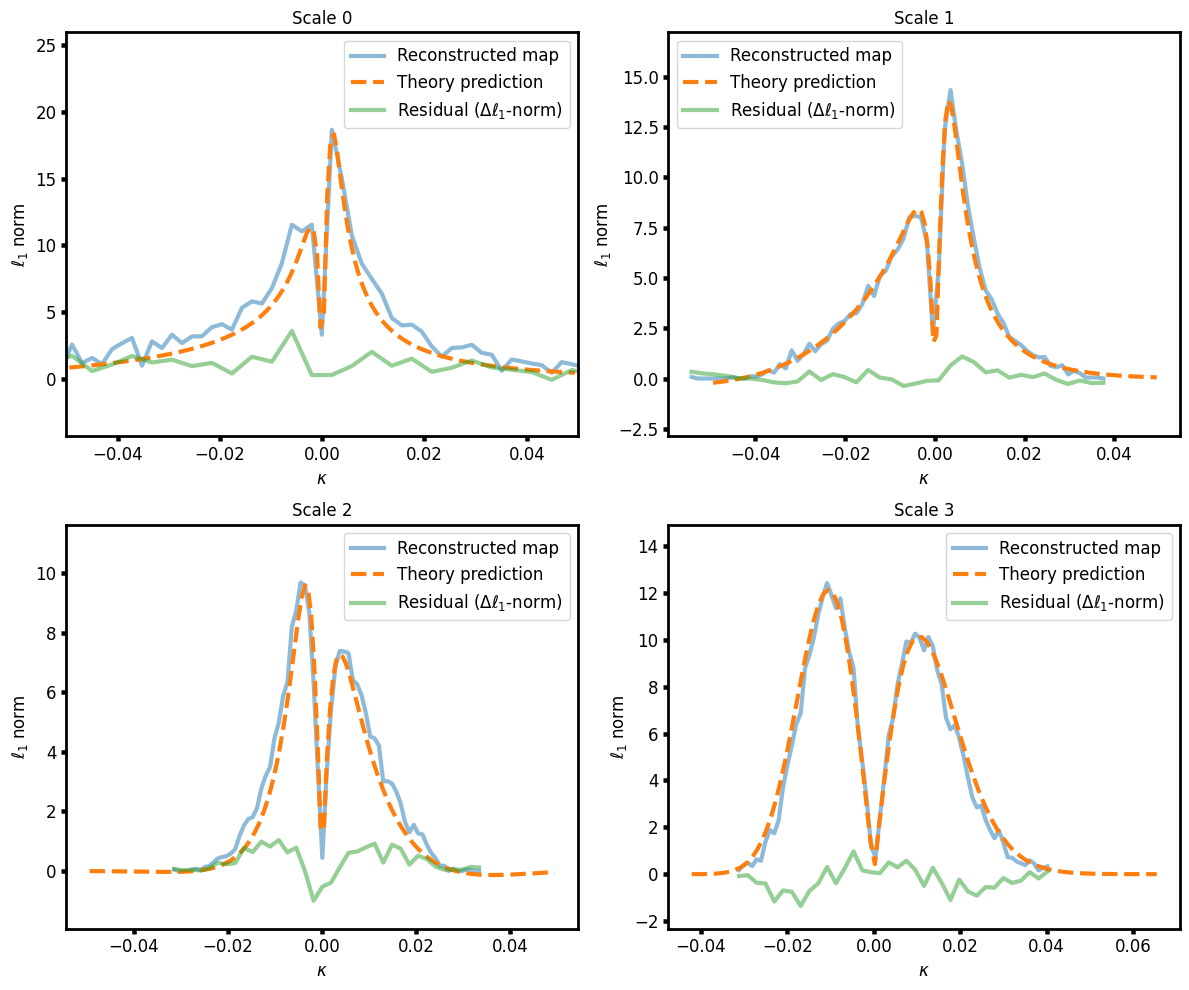

In [100]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for scale in range(nscales + 1):
    solution_edges, solution_centers, solution_hist, solution_l1norm = calculate_histogram_l1norm(
        solution_coefs[scale], mask=None, nbins=141, density=density
    )
    factor = target.shape[0] * target.shape[1] * (solution_edges[1] - solution_edges[0])
    row, col = scale // 2, scale % 2 
    axs[row, col].plot(solution_centers[::2], solution_l1norm[::2]*factor, label='Reconstructed map', alpha=0.5)
    axs[row, col].plot(
        target_values[f'scale_{scale}']['bincenters'], 
        target_values[f'scale_{scale}']['l1_norm']*factor, 
        label='Theory prediction', 
        ls="--"
    )
    
    # Residual calculation
    target_spline = CubicSpline(target_values[f'scale_{scale}']['bincenters'], target_values[f'scale_{scale}']['l1_norm'])
    residual = (solution_l1norm * factor) - (target_spline(solution_centers)*factor)
    
    axs[row, col].plot(solution_centers[::4], residual[::4], label=r'Residual ($\Delta \ell_1$-norm)', alpha=0.5)
    axs[row, col].legend()
    # axs[row, col].axhline(0, color='k', alpha=0.2)
    
    axs[row, col].set_title(f'Scale {scale}')
    axs[row, col].set_xlabel(r"$\kappa$")
    axs[row, col].set_ylabel(r"$\ell_1$ norm")
    
    y_min = np.min(solution_l1norm*factor) - (np.max(solution_l1norm*factor) / 5)
    y_max = np.max(solution_l1norm*factor) + (np.max(solution_l1norm*factor) / 5)
    axs[row, col].set_ylim(y_min, y_max)

axs[0,0].set_xlim(-0.05,0.05)

plt.tight_layout()
plt.show()
